*1.CONFIGURACION DEL ENTORNO*


Importamos las librerías y funciones personalizadas del proyecto para analizar, visualizar  y modelar

In [84]:
import pandas as pd
from src.modelado import categorizar_horas
from src.modelado import dividir_datos
from src.modelado import pipeline_preprocesamiento
from src.modelado import entrenar_modelo
from src.modelado import calcular_matriz_confusion
from src.modelado import graficar_matriz_confusion
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
import pickle
from sklearn.ensemble import RandomForestClassifier

*2.CARGAMOS LOS DATOS DEL DATASET LIMPIO*

Leemos el archivo CSV limpio que contiene los datos del estudio de tatuajes

In [85]:
df = pd.read_csv("../data/tattoo_studio_clean.csv")

*3.CREAMOS NUESTRAS VARIABLES OBJETIVO*

Transformamos  Session_Hours en una variable categórica (Session_Hours_Cat) usando la función categorizar_horas para poder clasificar la sesion en corto, mediano y largo

In [86]:
df["Session_Hours_Cat"] = df["Session_Hours"].apply(categorizar_horas)

4.SEPARAMNOS LA VARIABLE PREDICTORIA(X) Y OBJETIVA(Y)

definimos las variables y excluimos las columnas que contienen la duración real y su versión categorizada.

In [87]:
y = df["Session_Hours_Cat"]
X = df.drop(columns=["Session_Hours", "Session_Hours_Cat"])

*5. ENTRENAMIENTO Y PRUEBA*

Dividimos los datos en conjuntos de entrenamiento y prueba para poder entrenar el modelo con una parte de los datos y evaluar su desempeño con otra parte no vista.

In [88]:
X_train, X_test, y_train, y_test = dividir_datos(X, y)

*6. CREAAMOS PIPELINE DE PROCESAMIENTO*

 garantizar que los datos estén listos para el modelo.

In [89]:
preprocesamiento = pipeline_preprocesamiento(X)

*7. ENTRENAMIENTO CON RANDOMFOREST*

Nuestro objetivo es clasificar sesiones en categorías de duración a partir de múltiples variables heterogénea y random fores es  una solución precisa, interpretable y robusta.Lo utilizamos para predecir la categoría de duración de una sesión de tatuaje (Corto, Medio, Largo) en función de variables como el tamaño, estilo, artista y tipo de sesión.

In [90]:
modelo = RandomForestClassifier()
modelo = entrenar_modelo(preprocesamiento, X_train, y_train)

*8. DESEMPEÑO DEL MODELO CON UNA MATRIZ DE CONFUSION*

-El modelo acertó 238 veces en Corto, 86 en Medio, y 31 en Largo.


-el modelo confundió 37 sesiones Medio como Corto, y 6 como Largo.


-El modelo tiene buen desempeño en Corto y Largo, pero hay algo más de confusión en la clase Medio

In [91]:
y_pred = modelo.predict(X_test)
cm = calcular_matriz_confusion(y_test, y_pred)
cm

array([[230,  17,   0],
       [ 37,  78,   6],
       [  0,   1,  31]])

*9.MOSTRAR LA TABLA DE CONTENIDO DE MANERA GRAFICA*

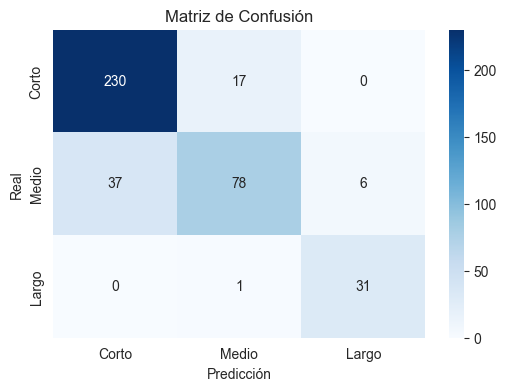

In [92]:
graficar_matriz_confusion(cm)


*10.COMPARACION ENTRE DURACION DEL TATUAJE REAL Y LA PREDICCION*

In [93]:
horas_reales = df.loc[X_test.index, "Session_Hours"]

*11.CATEGORIAS PREDICHAS A RANGO DE DURACION*

creamos una tabla que comprara la duración real de cada sesión con la categoría predicha por el modelo y  traducimos cada categoría  a un rango de horas específico para facilitar la interpretación y validar si la predicción tiene sentido frente a la duración real.

In [94]:
rango_categorias = {
    "Corto": "0–3 horas",
    "Medio": "3–6 horas",
    "Largo": "6+ horas"
}
comparacion = pd.DataFrame({
    "Horas_Reales": horas_reales.values,
    "Predicción_Categoría": y_pred
})
comparacion["Rango_Predicción"] = comparacion["Predicción_Categoría"].map(rango_categorias)
comparacion.head()

,Horas_Reales,Predicción_Categoría,Rango_Predicción
0,1,Corto,0–3 horas
1,3,Corto,0–3 horas
2,3,Corto,0–3 horas
3,2,Corto,0–3 horas
4,2,Corto,0–3 horas


*12.DISTRIBUCION DE LA DURACION DE LA SECION DE TATUAJE*

muestra cuántas sesiones caen en cada categoría de duración y nos ayuda a entender la distribucion de los tiempos, revelando que la mayoría de las sesiones son cortas, luego mediana y diciendo que las sesiones largas son las mas escasas.



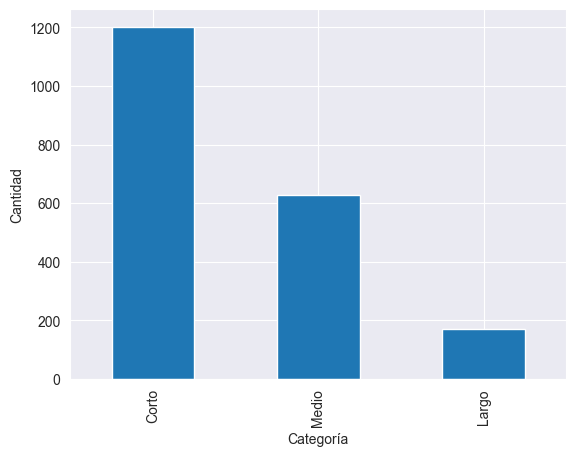

In [95]:
df["Session_Hours_Cat"].value_counts().plot(kind="bar")
plt.xlabel("Categoría")
plt.ylabel("Cantidad")
plt.show()

*13. CREAMOS LAS PREDICCIONES PARA EL CONJUNTO DE DATOS*

In [96]:
df_clean = df.copy()
df_clean["Predicted_Session"] = modelo.predict(X)

*14.COMPARACION ENTRE VALORES REALES VS PREDICHOS*

 Usamos barras agrupadas para visualizar cuántas sesiones fueron clasificadas como Corto, Medio o Largo, tanto en los valores reales como en la predicción.

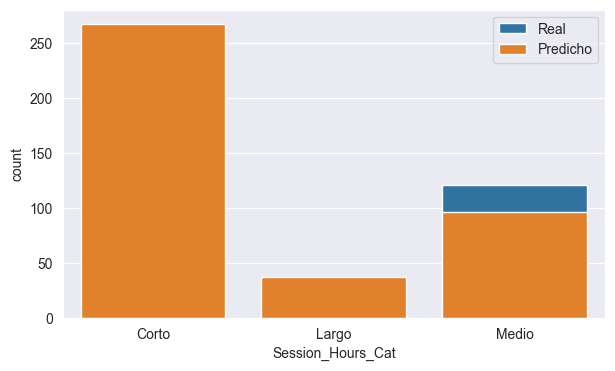

In [97]:
plt.figure(figsize=(7,4))
sns.countplot(x=y_test, label="Real")
sns.countplot(x=y_pred, label="Predicho")
plt.legend(["Real", "Predicho"])
plt.show()


*15. GRAFICO BOXPLOT DE LA DISTRIBUCION DE HORAS REALES CON SU DISTRIBUCION (CORTO,MEDIO,LARGO)*


Lo quqe podemos leer del grafico es que las sesiones cortas están concentradas entre 1 y 3 horas, con poca dispersión, la sesion media tiene mayor variabilidad con sesiones entre 3 y 6 horas, y una mediana más amplia y las sesiones largas superan las 6 horas, con mayor dispersión y algunos valores extremos.

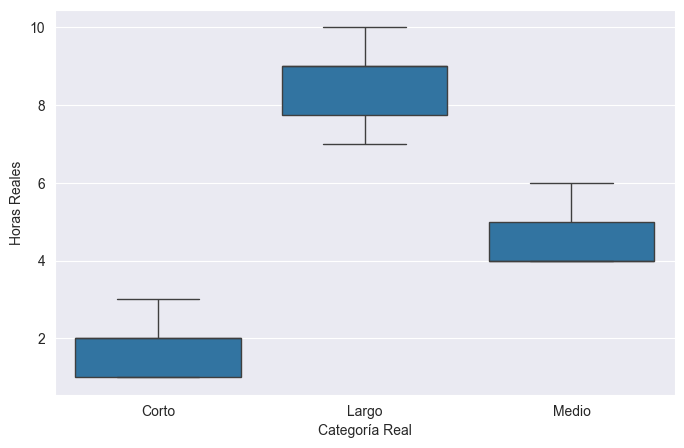

In [98]:
comparacion["Real_categ"] = comparacion["Horas_Reales"].apply(categorizar_horas)
comparacion["Predicho_categ"] = comparacion["Predicción_Categoría"]
comparacion.head()
plt.figure(figsize=(8,5))
sns.boxplot(x=comparacion["Real_categ"], y=comparacion["Horas_Reales"])
plt.xlabel("Categoría Real")
plt.ylabel("Horas Reales")
plt.show()


***16.GRAFICA DE SCATTER MATRIX EN RELACIN CON TAMAÑO DEL TATUAJE Y DURACION DE LA SESION.***

***HORAS POR SESION:*** nos dice que en su mayoria las sesiones duran entre 1 y 4 horas, con una caída progresiva hacia sesiones más largas.


***TAMAÑO DEL TATUAJE:*** Los tatuajes más comunes tienen tamaño 2 o 3, mientras que los tamaños extremos 1 y 5 son menos frecuentes.

***GRAFICO DE DISPERSION ENTRE TAMAÑO DEL TATUAJE Y DURACION:*** Se observa una tendencia positiva a medida que el tamaño del tatuaje aumenta, también lo hace la duración de la sesión. Esto sugiere que el tamaño es un buen predictor del tiempo necesario.


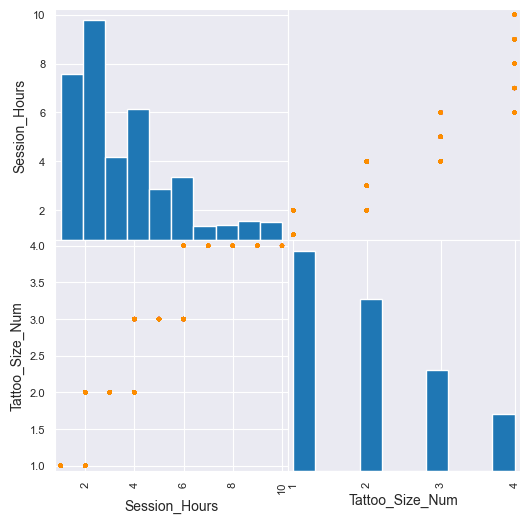

In [99]:
size_map = {
    "Small": 1,
    "Medium": 2,
    "Large": 3,
    "Sleeve/Back": 4
}
df["Tattoo_Size_Num"] = df["Tattoo_Size"].map(size_map)
vars_to_plot = ["Session_Hours", "Tattoo_Size_Num"]
scatter_matrix(df[vars_to_plot],
               figsize=(6, 6),
               diagonal='hist',
               alpha=0.7,
               color='darkorange')
plt.show()

*17. DISTRIBUCION DE SESIONES POR EL TAMAÑO DEL TATUAJE Y EL ESTILO*


Este gráfico de barras apiladas muestra cómo se reparten los tipos de sesión dentro de cada categoría de tamaño de tatuaje. Cada barra representa un tamaño, y los colores indican cuántas sesiones fueron agendadas previamente versus cuántas fueron espontáneas.

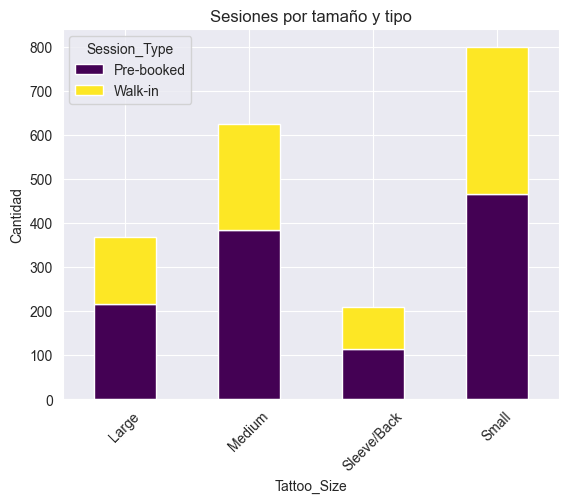

In [100]:
pd.crosstab(df["Tattoo_Size"], df["Session_Type"]).plot(kind="bar", stacked=True, colormap="viridis")
plt.title("Sesiones por tamaño y tipo")
plt.ylabel("Cantidad")
plt.xticks(rotation=45)
plt.show()



*18.PROMEDIO DE DURACION SEGUN EL ESTILO Y EL TAMAÑO DEL TATUAJE*

*Estilos como Realism y Custom:* requieren más tiempo, especialmente en tamaños grandes o tipo Sleeve/Back donde superan las 8 horas.

*Estilos Minimalist y Script:* tienden a ser más rápidos, con sesiones cortas incluso en tamaños grandes.

A medida que el tatuaje es más grande, la duración promedio aumenta en casi todos los estilos este patrón confirma que tanto el estilo como el tamaño son variables clave para predecir el tiempo de sesión, nos ayuda a planificar angenda y precio de un tatuaje.

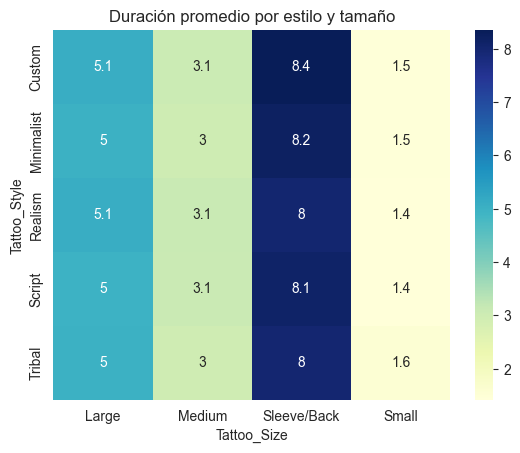

In [101]:
pivot = df.pivot_table(values="Session_Hours", index="Tattoo_Style", columns="Tattoo_Size", aggfunc="mean")
sns.heatmap(pivot, annot=True, cmap="YlGnBu")
plt.title("Duración promedio por estilo y tamaño")
plt.show()


*19.GUARDAMOS EL MODELO ENTRENADO*

In [102]:
with open("../data/modelo.pkl", "wb") as f:
    pickle.dump(modelo, f)